### Libraries

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from datetime import datetime
import pandas as pd
import math
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

## Data import

In [96]:
edge_counts = defaultdict(int)
timestamps = defaultdict(list)

with open("13_collegemsg_network/CollegeMsg.txt", "r") as f:
    for line in f:
        u, v, t = map(int, line.strip().split())
        edge_counts[(u, v)] += 1
        timestamps[(u, v)].append(datetime.fromtimestamp(t))

# Create directed graph
G = nx.DiGraph()
for (u, v), count in edge_counts.items():
    G.add_edge(u, v, weight=count)


In [97]:
# who has the most connections
deg_cen =nx.degree_centrality(G)

# returns a ranking of influential nodes
voterank = nx.voterank(G)

# dictionary of nodes and their pagerank score
# here higher weights should mean stronger influence IIRC
pagerank = nx.pagerank(G, weight='weight')

# dictionary like the previous one
# these can be used to identify nodes that are connected to other well connected nodes
eigenvec_cen = nx.eigenvector_centrality(G, weight='weight')


In [98]:
# for betweenness centrality, the weight is interpreted as the distance
# that is, they're used to compute the shortest path
# so using weight = number of messages
# would invert the relationship for very active connections
# i think we can invert the weights, so that more messages means shorter distance
# but idk

G_inverted = G.copy()
for u, v, data in G.edges(data=True):
    G_inverted[u][v]['weight'] = 1.0 / data['weight']  # invert weights


# btw, this identifies users that are on the shortest path between other users
# so they're important for spreading information
bet_cen = nx.betweenness_centrality(G_inverted, weight='weight')

# then we should find a smart way to combine this information with the rest

In [ ]:
# self-loops are treated as already formed communities by louvain below
# so we would need to remove them (or do something idk) with them first
# there are no self-loops tho luckily
list(nx.selfloop_edges(G))

[]

In [100]:
# finds communities by optimizing modularity
# side note, online i'm seeing that this algorithm is meant for undirected graphs
# but networkx has a version for directed graphs
# we could try converting the graph to undirected
# G_undirected = G.to_undirected()
# the communities would probably be quite different
# (what we have is valid tho, it's just that it might be more likely to get communities that are dominated by a few strong sources or strong sinks)
# but that can be useful

# last note: there are many other ways to find communities
# this was simple and apparently common
communities = nx.community.louvain_communities(G, weight='weight')

In [101]:
len(communities)

16

In [102]:
# a modularity higher than 0.3 means that there are more edges within
# the found communities than you'd expect by chance
nx.community.modularity(G, communities, weight='weight')

0.3580668218621236

In [103]:
nx.density(G)

0.005631048674611617

In [104]:
# ignoring directions
nx.number_weakly_connected_components(G)

4

In [105]:
# components where there's a path in both directions between any two nodes
nx.number_strongly_connected_components(G)

601

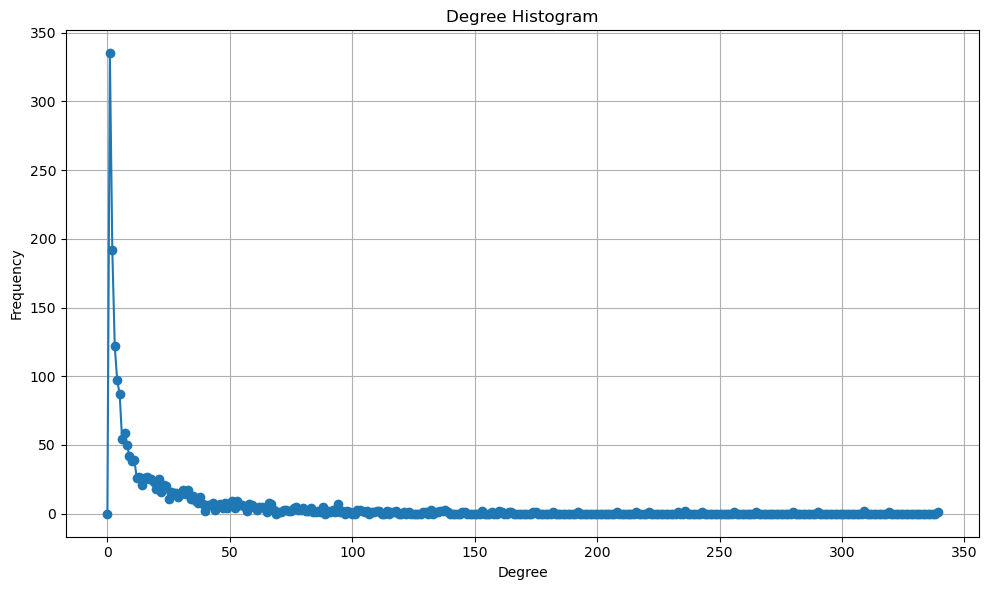

In [106]:
def plot(data, title, xlabel, ylabel):
	plt.figure(figsize=(10, 6))
	plt.plot(data, marker='o')
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	plt.grid(True)
	plt.tight_layout()
	plt.show()


plot(nx.degree_histogram(G), "Degree Histogram", "Degree", "Frequency")

In [107]:
nx.average_clustering(G)

0.08723899580135272

In [108]:
# dataframe with time
message_data = []
with open("13_collegemsg_network/CollegeMsg.txt", "r") as f:
    for line in f:
        u, v, t = map(int, line.strip().split())
        message_data.append({
            'src': u,
            'dest': v,
            'tmstmp': datetime.fromtimestamp(t)
        })

df = pd.DataFrame(message_data)

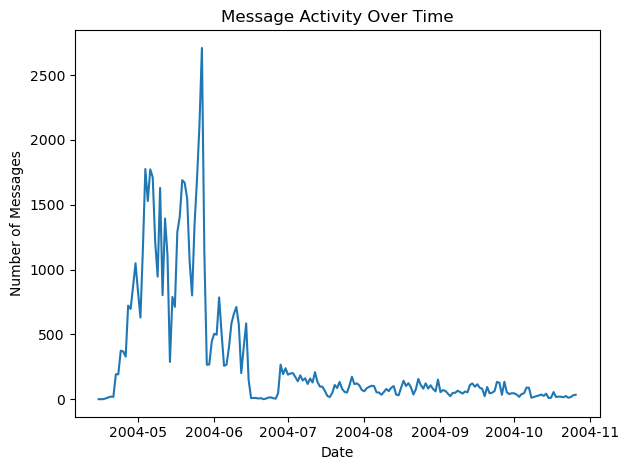

In [109]:
# plot messages / time
df['date'] = df['tmstmp'].dt.date
daily_counts = df.groupby('date').size()
daily_counts.plot(kind='line')
plt.title('Message Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.tight_layout()
plt.show()


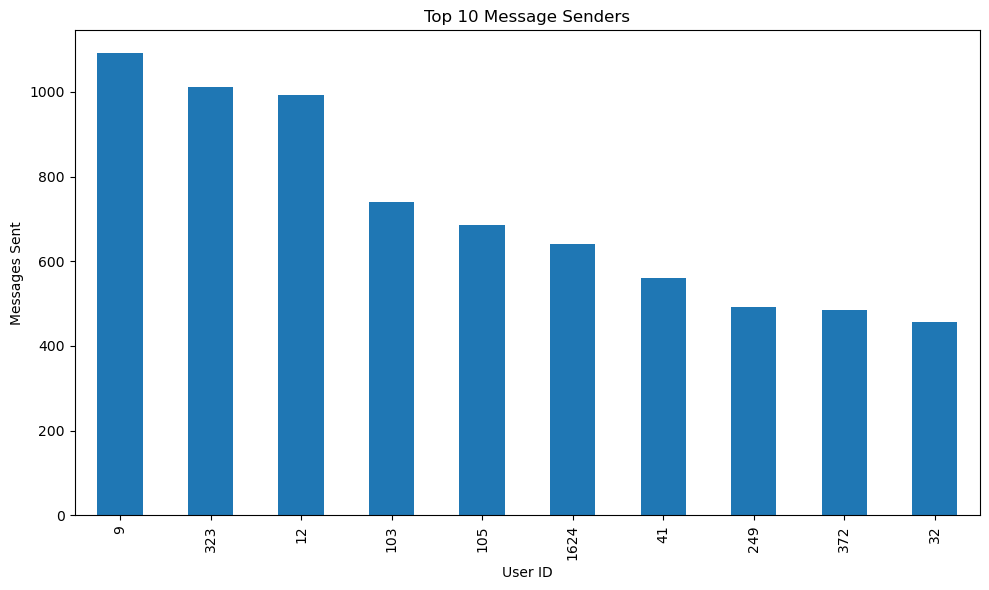

In [110]:
# plot top senders
top_senders = df['src'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_senders.plot(kind='bar')
plt.title('Top 10 Message Senders')
plt.xlabel('User ID')
plt.ylabel('Messages Sent')
plt.tight_layout()
plt.show()

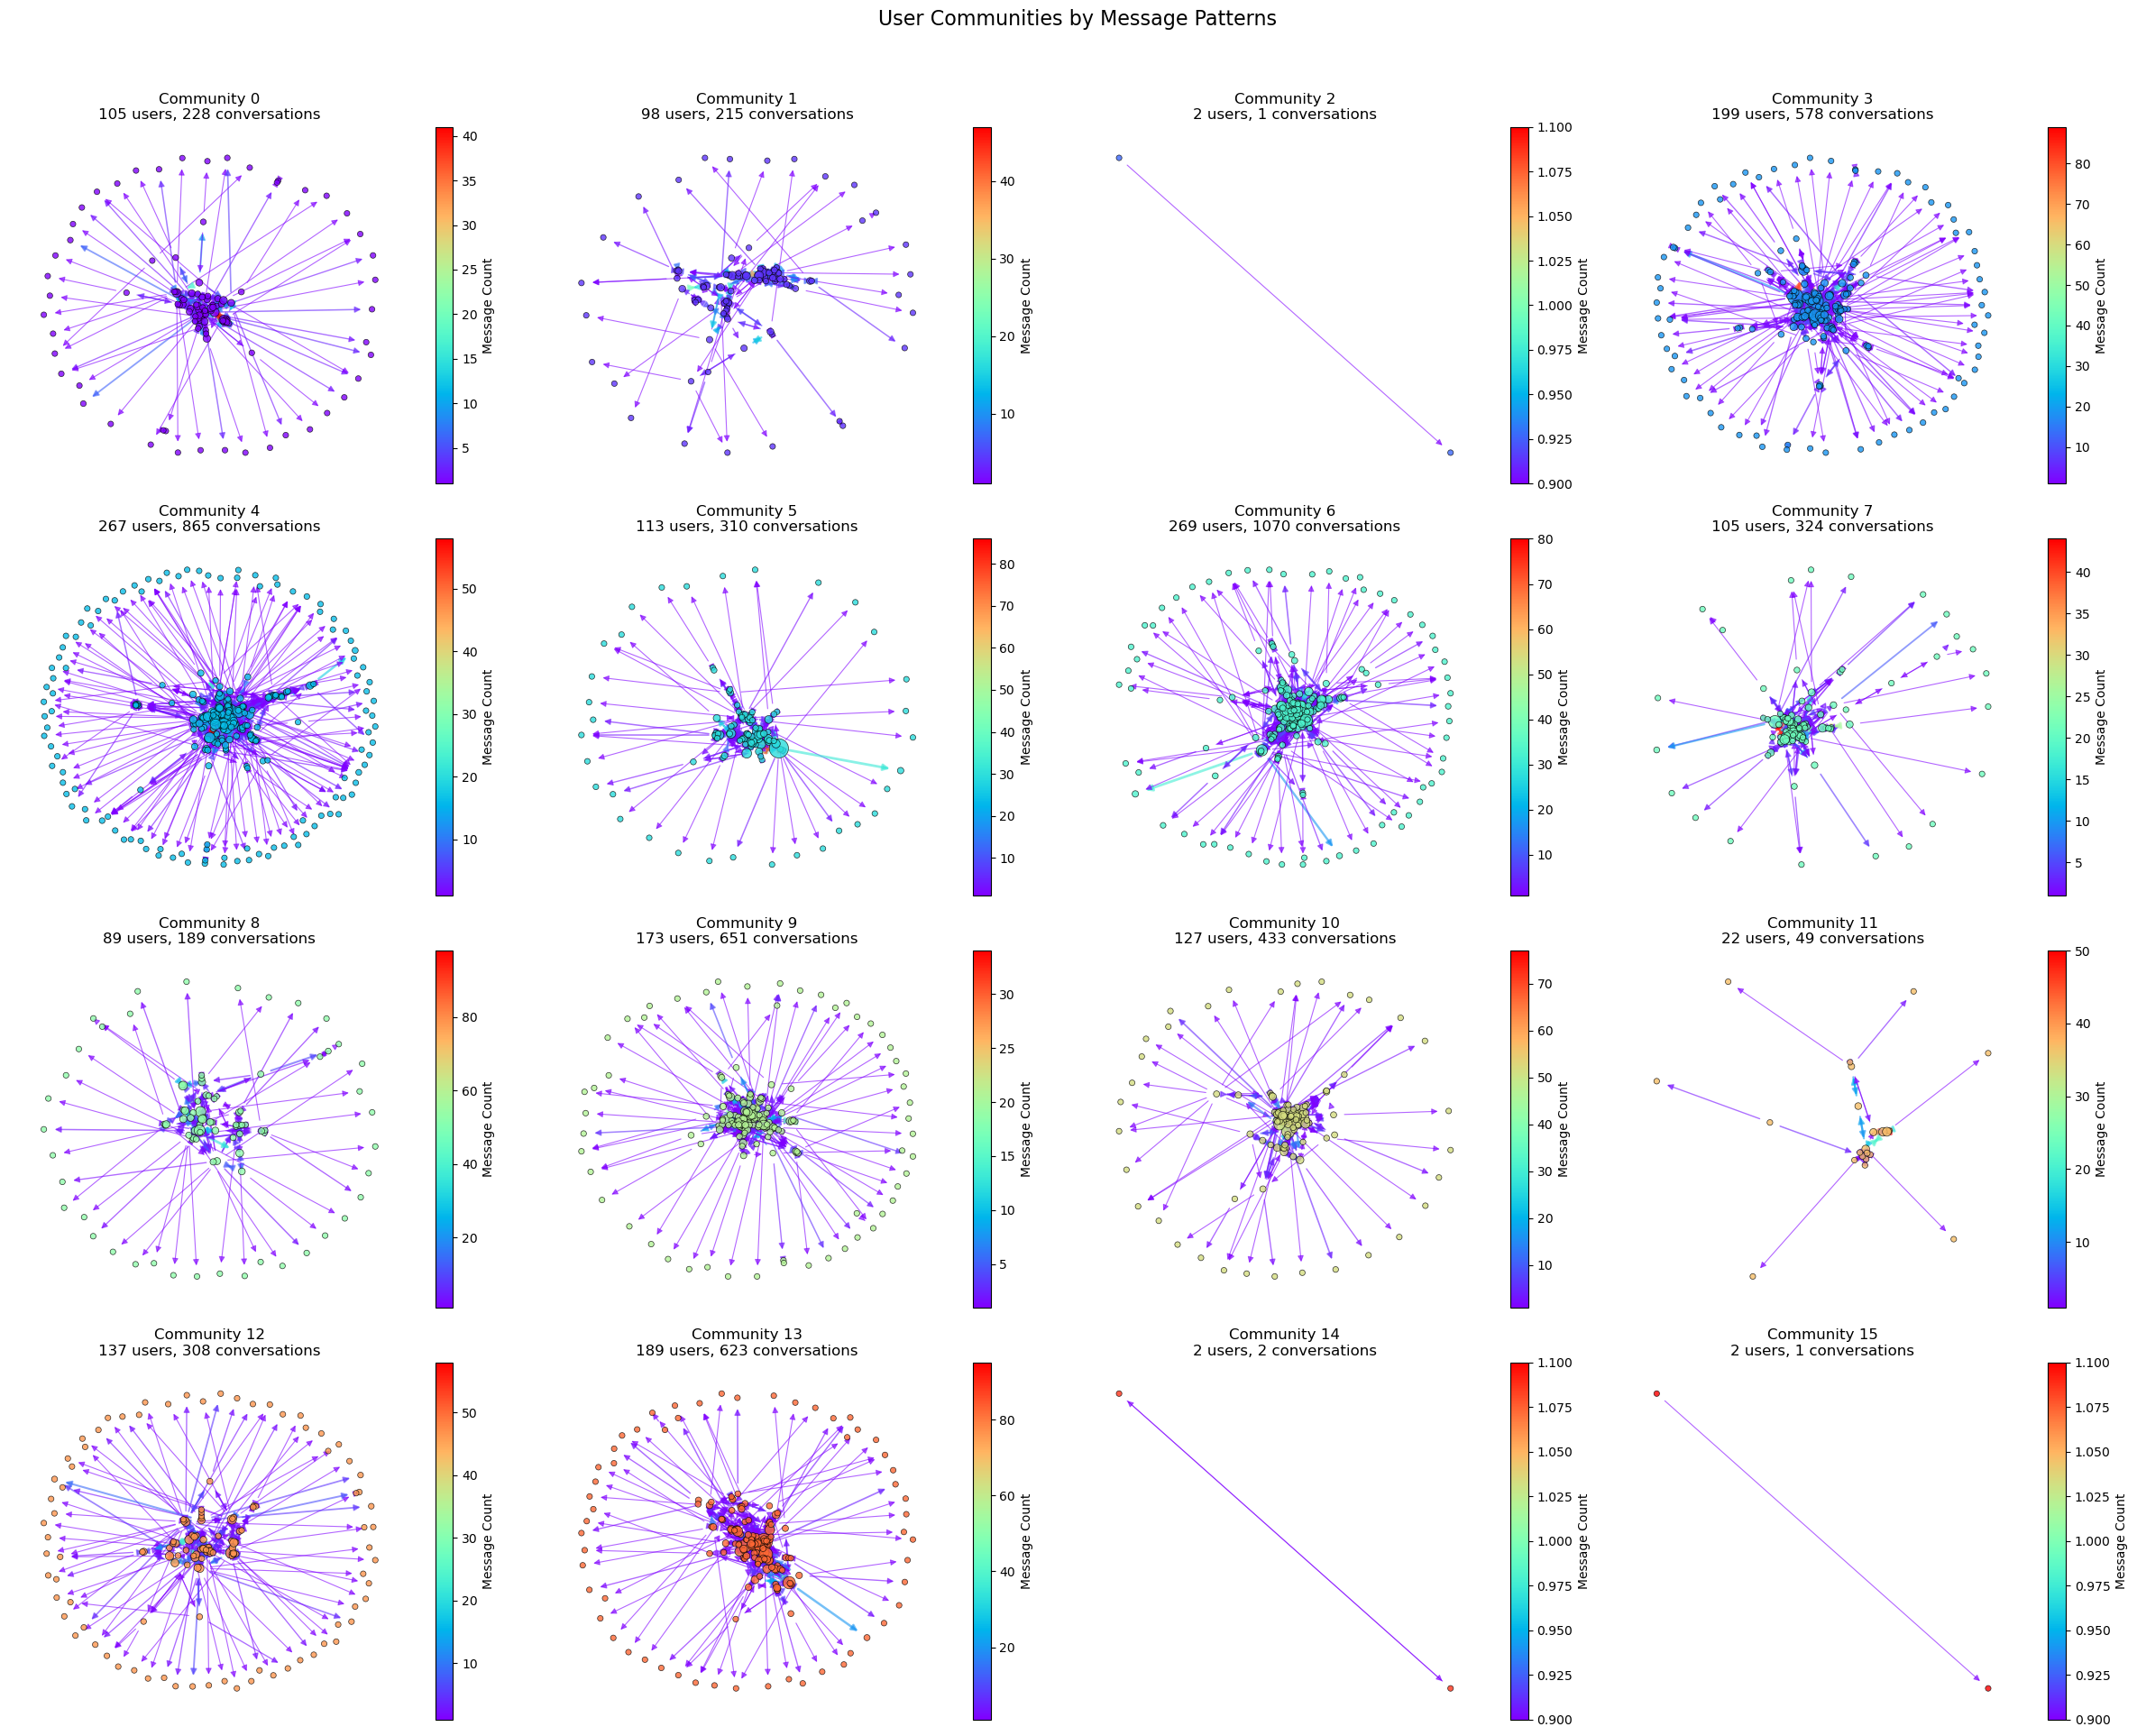

In [ ]:
# -------- plotting communities --------

num_communities = len(communities)
cols = math.ceil(math.sqrt(num_communities))
rows = math.ceil(num_communities / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

# colors
cmap = plt.cm.rainbow
community_colors = cmap(np.linspace(0, 1, num_communities))

# normalizing for consistent scaling, might need adjustments
all_weights = [d['weight'] for u, v, d in G.edges(data=True)]
global_max_weight = max(all_weights) if all_weights else 1
global_degrees = dict(G.degree(weight='weight'))
global_max_degree = max(global_degrees.values()) if global_degrees else 1

for i, comm_nodes in enumerate(communities):
    ax = axes[i]
    comm_set = set(comm_nodes)

    # a subgraph for each community
    subgraph = G.subgraph(comm_nodes).copy()

    if subgraph.number_of_nodes() > 0:
        # k is the optimal distance between nodes in the layout
        # increasing k will spread out the nodes more
        k = 0.7 / math.sqrt(subgraph.number_of_nodes()) if subgraph.number_of_nodes() > 1 else 0.3
        sub_pos = nx.spring_layout(
            subgraph,
            seed=42,
            k=k,
            iterations=100,
            weight='weight'  # heavier edges should be "attracted" more, thus shorter
        )


        sub_edge_weights = nx.get_edge_attributes(subgraph, 'weight')
        sub_edges, sub_weights = zip(*sub_edge_weights.items()) if sub_edge_weights else ([], [])

        # this is is using the weighted degree, but maybe they look too similar like this
        # in that case we might not need to normalize
        # anyway, the size is proportional to the number of connections to other users
        weighted_degrees = dict(subgraph.degree(weight='weight'))
        node_sizes = [300 * (weighted_degrees[n] / global_max_degree) + 20 for n in subgraph.nodes()]

        # logarithmic scaling (according to DeepSeek, didn't check this lol)
        # anyway, this is supposed to prevent huge variations in length because most users are not very active, I think
        # and a few send a lot
        # i still think the nodes are too aggregated in the middle but we can tweak that
        sub_widths = [2 * math.log(w + 1) / math.log(global_max_weight + 1) + 0.5 for w in sub_weights] if sub_weights else [0.5]

        # this is also coloring the edges by weight but maybe there are too many colors now lol
        # comment this out if you want them all gray (and in draw edges two blocks down)
        edge_norm = Normalize(vmin=min(sub_weights, default=0), vmax=max(sub_weights, default=1))
        edge_colors = [cmap(edge_norm(w)) for w in sub_weights]

        # the nodes are colored by community now
        # but since i'm plotting them separately this is kinda stupid
        # we can add another colorbar and color them by degree or something else
        # or keep them all the same color
        nx.draw_networkx_nodes(
            subgraph, sub_pos, ax=ax,
            node_size=node_sizes,
            node_color=[community_colors[i]] * subgraph.number_of_nodes(),
            alpha=0.8,
            linewidths=0.5,
            edgecolors='black'
        )


        nx.draw_networkx_edges(
            subgraph, sub_pos, ax=ax,
            edgelist=sub_edges,
            width=sub_widths,
            alpha=0.6,
            edge_color=edge_colors if sub_weights else 'gray'
            # edge_color='gray'  # comment this line if you want colored edges
        )



        # colorbar for edge weights
        if sub_weights:
            sm = ScalarMappable(norm=edge_norm, cmap=cmap)
            sm.set_array([])
            plt.colorbar(sm, ax=ax, label='Message Count')

        ax.set_title(f"Community {i}\n{len(comm_nodes)} users, {len(sub_edges)} conversations")
    else:
        ax.set_title(f"Community {i} (Empty)")

    ax.axis('off')

    # hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

plt.suptitle("User Communities by Message Patterns", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.show()

In [112]:
# we could try taking "snapshots" of the network at different times to see how it evolves